# Is ERA5 land a good data set to calculate PV generation?
well, we will see

description: this script validates PV output from ERA5 land data using pv installations data from chile. 
            The calculation of the PV output from ERA5 land data takes place externally in the script: 
            "PV_time_series_ERA5_land_chile.py" this is due to performance issues.
            The resulting dataframe is re-loaded here and compared against the official PV output data of
            103 PV installations conected to the grid in Chile.


## 1) import the libraries and data

In [1]:
import os
import itertools
import xarray as xr
import pvlib
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import geopandas
import glob
from tkinter import Tcl
import gc
import unidecode
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import scipy as sp
import scipy.stats
import seaborn as sns
#define the data sets that are going to be used
installations_chile_pre = "/home/lramirez/my-data/pv_generation_per_country/chile/solares_fd0779de_0870_4194_b962_83a842d8c316.shp"
#load the list of files with pv generation data
#for the chilean case avoid loading the files with "old" in the file name
generation_chile_pre = list(glob.glob("/home/lramirez/my-data/pv_generation_per_country/chile/OP*[!old].xls"))
generation_chile = Tcl().call('lsort', '-dict', generation_chile_pre)
#The format of the xlc is slitghtly different between files. 
#For the files between 2014-01-01 and 2016-02-11 the header is in line 3 of the sheet ‘gen_real’ 
#from 2016-02-12 the header is in the line 4.
#the list of files will be divided in 2
available_days = len(generation_chile)
generation_chile1 = generation_chile[0:772]
generation_chile2 = generation_chile[772:]
#define the ratio for matching the names of the chilean PV installations
matching_ratio = 70

#load the list of files with pv generation data from energía abierta for the sen (should include sic and sing https://www.coordinador.cl/operacion/graficos/operacion-real/generacion-real-del-sistema/?radio-formato=xlsx)
generation_chile_pre_sen = list(glob.glob("/home/lramirez/my-data/pv_generation_per_country/chile/energia_abierta/*.xlsx"))
generation_chile_sen = Tcl().call('lsort', '-dict', generation_chile_pre_sen)

In [2]:
#import the locations of PV plants in Chile
#transfrom to wg84 coordinates and addapt the longitudes to the ERA5 land data
pvs_chile = geopandas.read_file(installations_chile_pre)

pvs_chile['geometry']
pvs_chile.crs
pvs_chile_4326 = pvs_chile.to_crs(epsg=4326)
pvs_chile_4326
#before runing the next step the installations of all countries have to be merged in the same list!
#for the first try only with the data from chile the names call is made directly from the shp
#it could also be that is better to work with every country separately?? or make new IDS for the installations?
installations_list = pvs_chile_4326["NOMBRE"]

#create a dataframe with the key data that is necesary for the comparison
installations_chile = pd.DataFrame({'latitude': pvs_chile_4326.geometry.y.values , 
                        'longitude': pvs_chile_4326.geometry.x.values + 360 , 
                        'size': pvs_chile_4326['POTENCIA'].values, 
                        'start_time': pd.to_datetime(pvs_chile_4326['F_OPERACIO'].values), 
                        'end_time': pd.to_datetime('2018-12-30')},
                       index=installations_list)
#installations_chile
#pvs_chile
#installations_chile.loc[installations_chile["size"]<=1]


## 2) create data frames for the installations and the measured generation

In [3]:
installations_with_no_match = ("SOLAR PSF PAMA",  
                               "SOLAR EL PILAR - LOS AMARILLOS", 
                               "SOLAR LOMA LOS COLORADOS",
                               "SOLAR LUNA",
                               "SOLAR DONA CARMEN",
                               "SOLAR EL PELICANO", 
                               "SOLAR PAMA", 
                               "SOLAR OLIVILLO",
                               "SOLAR EL CHINCOL",
                               "SOLAR CATAN", 
                               "SOLAR LAS PALOMAS")
forced_match = {"SOLAR LAGUNILLA":"PFV LAGUNILLA", 
                "SOLAR LALACKAMA 2":"LALACKAMA 2", 
                "SOLAR LALACKAMA":"LALACKAMA",
                "SOLAR TAMBO REAL":"TAMBO REAL",
                "SOLAR SAN ANDRÉS":"SOLAR SAN ANDRES",
                "SOLAR LUZ DEL NORTE":"LUZ DEL NORTE",
                "SOLAR PAMPA SOLAR NORTE":"PAMPA SOLAR NORTE",
                "SOLAR PV CONEJO":"CONEJO SOLAR", 
                "SOLAR CARRERA PINTO":"CARRERA PINTO ETAPA I",
                "SOLAR SAN PEDRO":"PFV SAN PEDRO",
                "SOLAR LA QUINTA":"LA QUINTA SOLAR",
                "SOLAR CERNICALO 1":"EL CERNICALO 1",
                "SOLAR CERNICALO 2":"EL CERNICALO 2",
                "SOLAR SAN FRANCISCO":"SAN FRANCISCO SOLAR",
                "SOLAR TALHUEN":"TALHUEN", 
                "SOLAR ANDES":"ANDES SOLAR", 
                "SOLAR LA HUAYCA 2":"SPS LA HUAYCA", 
                "SOLAR PILOTO CARDONES":"PILOTO SOLAR CARDONES",
                "SOLAR LUDERS":"PFV LUDERS", 
                "SOLAR TIL TIL":"TILTIL SOLAR", 
                "SOLAR PUERTO SECO":"PUERTO SECO SOLAR", 
                "SOLAR SANTIAGO":"SANTIAGO SOLAR", 
                "SOLAR URIBE":"URIBE SOLAR",
                "SOLAR SAN FRANCISCO ":"SAN FRANCISCO SOLAR",
                "SOLAR PICA ":"PMGD PICA PILOT",
                "SOLAR SOL":"SOL DEL NORTE", 
                "SOLAR OCOA":"OCOA", 
                "SOLAR PORTEZUELO":"PORTEZUELO", 
                "SOLAR SAN FRANCISCO":"SAN FRANCISCO SOLAR",
                "SOLAR VILLA PRAT":"VILLA PRAT",
                "SOLAR CALAMA 1":"CALAMA SOLAR 1",
                "SOLAR FRANCISCO":"FRANCISCO SOLAR", 
                "SOLAR RODEO":"RODEO",
                "SOLAR SANTA LAURA":"SANTA LAURA", 
                "SOLAR SANTUARIO":"SANTUARIO SOLAR"}

In [4]:
#create a data frame for the time series of energy generation of each plant of the sen data set
date_range = pd.date_range(start='1/1/2014', end='01/01/2019', freq='H', tz='Chile/Continental')
date_range_m = pd.date_range(start='1/1/2014', end='31/12/2018', freq='M', tz='Chile/Continental')
#print(date_range_m)
days_all = pd.date_range(start='1/1/2014', end='31/12/2018', freq='D')
timeseries_installations_sen = pd.DataFrame(columns=installations_list, index=pd.to_datetime(date_range))
file = 0
day_counter = 0
for month in date_range_m:
    output_chile = pd.read_excel(generation_chile_sen[file], sheet_name='Sheet', header=3)
    for day in days_all[day_counter:]:
        #print(day)
        output_chile_day = (output_chile.loc[(output_chile["Tipo"]=="Solar") &
                                         (output_chile["Fecha"]==((str(day))[:-9]))])
        start_hour = day_counter * 24
        stop_hour = start_hour + 24
        #print(str(day_file)+"  "+str(start_hour)+" "+str(stop_hour))
        #go through all installations in a day and store the hourly values in timeseries_installations_sen
        for installations in output_chile_day.index:
            installation = unidecode.unidecode(output_chile_day.loc[installations]["Grupo reporte"].upper())
            #print(installation)
            hourly_values = output_chile_day.loc[installations][6:30]
            if installation in timeseries_installations_sen.columns:
                timeseries_installations_sen[installation][start_hour:stop_hour] = \
                hourly_values
                #print(str(installation) + "*")
            elif str('SOLAR '+str(installation)) in timeseries_installations_sen.columns:
                timeseries_installations_sen['SOLAR '+str(installation)][start_hour:stop_hour] = \
                hourly_values
                #print(str(installation) + "**")
            elif installation in installations_with_no_match:
                #print(str(installation) + " is part of the list without a match")
                pass
            elif installation in forced_match:
                #print(str(installation) + " is part of the list with forced match")
                timeseries_installations_sen[forced_match[installation]][start_hour:stop_hour] = \
                hourly_values
            else:
                #print(installation)
                running_ratio = matching_ratio
                for installation_not_match in timeseries_installations_sen.columns:
                    if fuzz.partial_ratio(installation,installation_not_match)> matching_ratio and \
                    fuzz.partial_ratio(installation,installation_not_match)> running_ratio:
                        running_ratio = fuzz.partial_ratio(installation,installation_not_match)
                        #print(str(fuzz.partial_ratio(installation,installation_not_match)) + " " + 
                                #str(installation)+ " " +str(installation_not_match))
                        timeseries_installations_sen[installation_not_match][start_hour:stop_hour] = \
                        hourly_values
        day_counter += 1
        if day in date_range_m:
            file += 1
            #print(str(day)+" end of the month "+str(file))
            break


# Measured data preparation

In [5]:
#normalized based on the maximum value after cleaning the outlayers
reference_pre1 = timeseries_installations_sen
for i in timeseries_installations_sen.columns:
    generation_raw1 = timeseries_installations_sen[i].dropna().copy()
    if np.sum(generation_raw1) > 0:
        installation_size = (np.percentile(generation_raw1,99))
        outliers_threshold = installation_size * 1.1
        #transfrom the outlayers into nan
        generation_raw2 = timeseries_installations_sen[i].where(timeseries_installations_sen[i] < outliers_threshold, 
                                                                np.nan).copy()
        #normalize by the maximum value after cleaning the outlayers
        #reference_pre1[i] = ((generation_raw2/np.max(generation_raw2))*1000).copy()
        reference_pre1[i] = ((generation_raw2/np.max(generation_raw2))).copy()
        #uncomment to se examples of the outlayers cleaning
        #print(i)
        #print(installation_size)
        #print(outliers_threshold)
        #fig = plt.figure(figsize=(20,6))
        #plt.plot(generation_raw1)
        #plt.plot(generation_raw2)
        #plt.show()               
#exclude all 0.0 values from the data set 
### four stations are drop because they have less than 2 month of observations
#LA ACACIA   1
#LOS PATOS   1
#RODEO   1
#SANTA LAURA   1
reference_pre2 = reference_pre1.tz_convert('UTC').drop(["LA ACACIA", "LOS PATOS", "RODEO", "SANTA LAURA","VILLA PRAT"], axis=1).where(reference_pre1 > 0.0, np.nan).copy()        


## 3) Import the PV output calculated with ERA5 data

In [6]:
#import and divide by the size to obtain a capacity factor per hour between 0 and 1
cf_factor = 1000
calculated_pre2 =  (pd.read_csv("dataframe_pv_output_chile_inverted_aspect.csv", index_col=0, parse_dates=True)/cf_factor)

In [7]:
calculated_pre1 = calculated_pre2.tz_localize('UTC').drop(["LA ACACIA", "LOS PATOS", "RODEO", "SANTA LAURA","VILLA PRAT"], axis=1).copy()

#the dailight summer time in chile changes from year to year
#the next lines create in a very explcit way a new time series with corrected dts
calculated_pre1_dst_2014 = calculated_pre1["2014-04-27":"2014-09-07"].shift(periods=-1).copy()
#calculated_pre1_dst_2015 = calculated_pre1["2015"].shift(periods=-1).copy()
calculated_pre1_dst_2016 = calculated_pre1["2016-05-15":"2016-08-14"].shift(periods=-1).copy()
calculated_pre1_dst_2017 = calculated_pre1["2017-05-14":"2017-08-14"].shift(periods=-1).copy()
calculated_pre1_dst_2018 = calculated_pre1["2018-05-13":"2018-08-12"].shift(periods=-1).copy()

calculated = calculated_pre1.copy()
calculated.loc["2014-04-27":"2014-09-07"] = calculated_pre1_dst_2014
#calculated.loc["2015"] = calculated_pre1_dst_2015
calculated.loc["2016-05-15":"2016-08-14"] = calculated_pre1_dst_2016 
calculated.loc["2017-05-14":"2017-08-14"] = calculated_pre1_dst_2017
calculated.loc["2018-05-13":"2018-08-12"] = calculated_pre1_dst_2018

## 4) Indicators calculation for the validation ERA5-land

In [8]:
minimum_months = 12/60
indicators = pd.DataFrame(columns=("pearson_h","p-value_h",
                                   "mbe_h",
                                   "rmse_h",
                                   "observations",
                                   "pearson_d",
                                   "mbe_d",
                                   "rmse_d",
                                   "days",
                                   "pearson_m",
                                   "mbe_m",
                                   "rmse_m",
                                   "months"), index=calculated.columns)
for plant in calculated.columns:
    if np.sum(reference_pre2[plant]["2014":"2018"]) > 0:
        #print(plant)
        comp_pre = pd.DataFrame(columns=("new","reference"), index=calculated.index)
        #print(np.array(calculated.index).size)
        comp_pre["new"] = np.array(calculated[plant]["2014":"2018"]).copy()
        #print(np.array(reference_pre2[plant]["2014":"2018"].copy()).size)
        comp_pre["reference"] = reference_pre2[plant]["2014":"2018"].copy()
        comp = comp_pre.dropna().copy()
        new = comp["new"]
        reference = comp["reference"]
        pearson = sp.stats.pearsonr(reference.astype(float), new.astype(float))
        indicators.loc[plant]["pearson_h"] = pearson[0]
        indicators.loc[plant]["p-value_h"] = pearson[1]
        indicators.loc[plant]["mbe_h"] = (np.sum(new-reference))/np.sum(reference.size)
        observations = comp.size/comp.columns.size
        indicators.loc[plant]["observations"] = observations
        indicators.loc[plant]["rmse_h"] = np.sqrt((np.sum((new-reference)**2))/(observations))
        #indicators.loc[plant]["rmse_r_h"] = np.sqrt((np.sum((new-reference)**2))/observations)/(np.sum(reference/observations))
        new_avg_day = round(new.resample('D').mean(),4).dropna().copy()
        days = new_avg_day.size
        days_in_study_period = 1825
        indicators.loc[plant]["days"] = days/days_in_study_period
        reference_avg_day = round(reference.astype(float).resample('D').mean(),4).dropna().copy()
        pearson_days = sp.stats.pearsonr(reference_avg_day.astype(float), new_avg_day.astype(float))
        indicators.loc[plant]["pearson_d"] = pearson_days[0]
        indicators.loc[plant]["mbe_d"] = (np.sum(new_avg_day-reference_avg_day))/np.sum(reference_avg_day.size)
        indicators.loc[plant]["rmse_d"] = np.sqrt((np.sum((new_avg_day-reference_avg_day)**2))/(np.sum(reference_avg_day.size)))
        new_avg_month = round(new.resample('M').mean(),4).dropna().copy()
        months = new_avg_month.size 
        reference_avg_month = round(reference.astype(float).resample('M').mean(),4).dropna().copy()
        pearson_months = sp.stats.pearsonr(reference_avg_month.astype(float), new_avg_month.astype(float))
        indicators.loc[plant]["pearson_m"] = pearson_months[0]
        indicators.loc[plant]["mbe_m"] = (np.sum(new_avg_month-reference_avg_month))/np.sum(reference_avg_month.size)
        indicators.loc[plant]["rmse_m"] = np.sqrt((np.sum((new_avg_month-reference_avg_month)**2))/(np.sum(reference_avg_month.size)))
        monthss_in_study_period = 60
        indicators.loc[plant]["months"] = months/monthss_in_study_period
        #print(str(plant)+"   "+str(months))
        #fig = plt.figure(figsize=(20,6))
        #plt.plot(new_avg_day)
        #plt.plot(reference_avg_day)
        #fig = plt.figure(figsize=(20,6))
        #plt.plot(new)
        #plt.plot(reference)
        #plt.show()
        #print(indicators.loc[plant])


In [9]:
indicators_clean = indicators.dropna().copy()
indicators_clean.to_csv("indicators_ERA5_land.csv")


In [10]:
results_pre = pd.read_csv("indicators_ERA5_land.csv", index_col=0)
#months_more_than_one_year = np.percentile(results_pre["months"], 58)
#print(months_more_than_one_year*60)
selected_results = results_pre.loc[results_pre["months"] > minimum_months].drop(["observations", "p-value_h","days","months"], axis=1).copy()
results = results_pre.drop(["observations", "p-value_h","days","months"], axis=1).copy()
#selected_results2 excludes 34 installations with objects, 
#long period of test before going fully online, long periods of missing values after commisioning day 
selected_results2 = selected_results.drop(["BELLAVISTA", "CARRERA PINTO ETAPA I",
                                           "CHANARES", "CONEJO SOLAR",
                                           "CORDILLERILLA","EL DIVISADERO",
                                           "FV BOLERO", "LAS TURCAS",
                                           "LOS PUQUIOS", "LUZ DEL NORTE",
                                           "PAMPA SOLAR NORTE", "PARQUE SOLAR CUZ CUZ",
                                           "PARQUE SOLAR FINIS TERRAE", "PARQUE SOLAR PAMPA CAMARONES",
                                           "PFV LAGUNILLA", "PFV LOS LOROS",
                                           "PLANTA PV CERRO DOMINADOR", "PMGD PICA PILOT",
                                           "PV SALVADOR", "QUILAPILUN",
                                           "SDGX01", "SOLAR ANTAY",
                                           "SOLAR DIEGO DE ALMAGRO", "SOLAR EL AGUILA I",
                                           "SOLAR EL ROMERO", "SOLAR ESPERANZA",
                                           "SOLAR HORMIGA", "SOLAR JAVIERA",
                                           "SOLAR LA SILLA", "SOLAR LAS TERRAZAS",
                                           "SOLAR LLANO DE LLAMPOS", "SOLAR SAN ANDRES",
                                           "SOLAR TECHOS ALTAMIRA", "TAMBO REAL"])
#selected results 3 excludes installations 
selected_results3 = selected_results2.drop(["PUERTO SECO SOLAR", "URIBE SOLAR",
                               "ANDES SOLAR", "LA CHAPEANA","LA QUINTA SOLAR",
                                "PILOTO SOLAR CARDONES", "SAN FRANCISCO SOLAR",
                                "SANTA JULIA","MARIA ELENA FV","LALACKAMA",
                                "LALACKAMA 2","LAS ARAUCARIAS","SOLAR CHUCHINI",
                                "SOLAR JAMA 1", "SOLAR JAMA 2","TILTIL SOLAR","VALLE DE LA LUNA II"])

(88, 9)

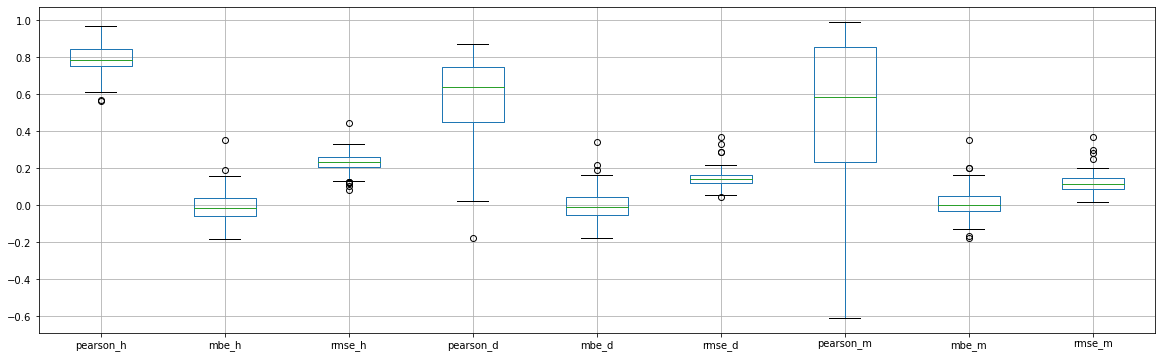

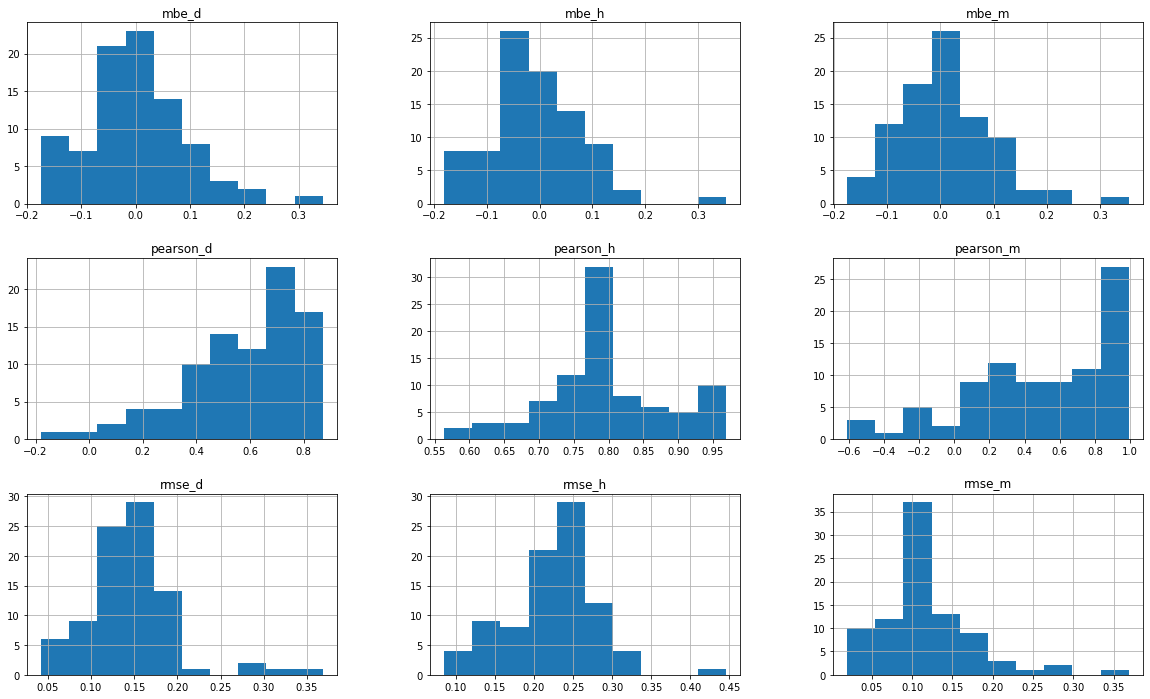

In [11]:
boxplot = results.boxplot(figsize=(20,6))
results.hist(figsize=(20,12))
results.shape

(57, 9)

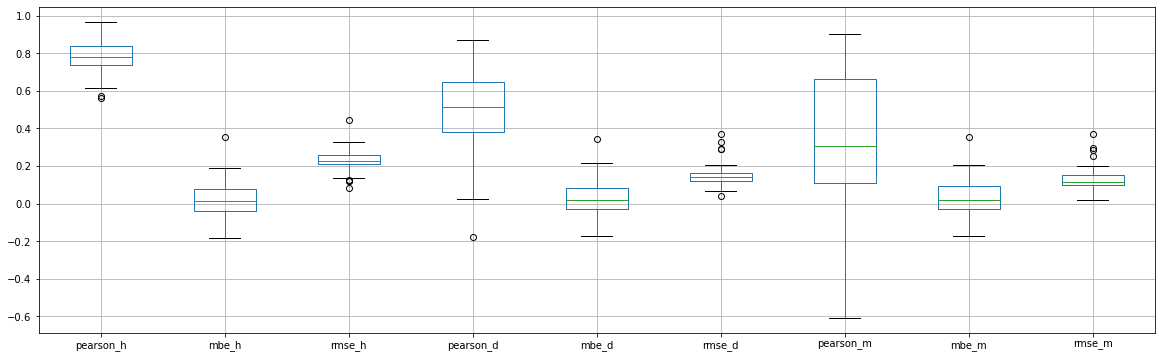

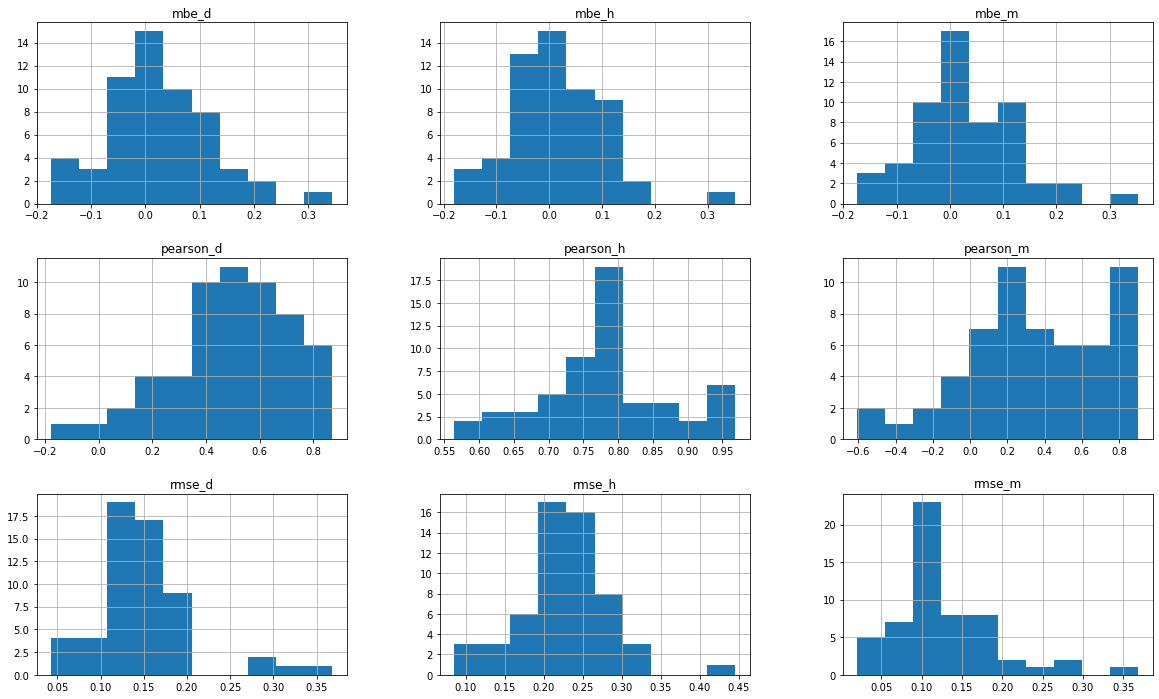

In [12]:
boxplot = selected_results.boxplot(figsize=(20,6))
selected_results.hist(figsize=(20,12))
selected_results.shape

(23, 9)

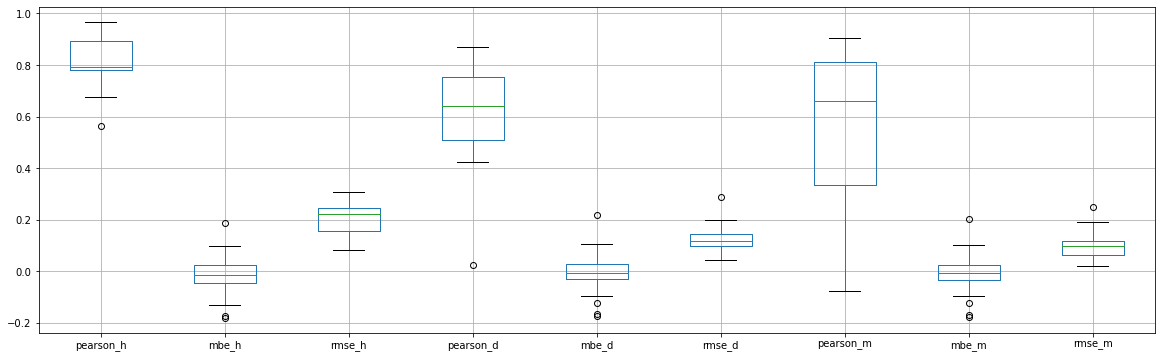

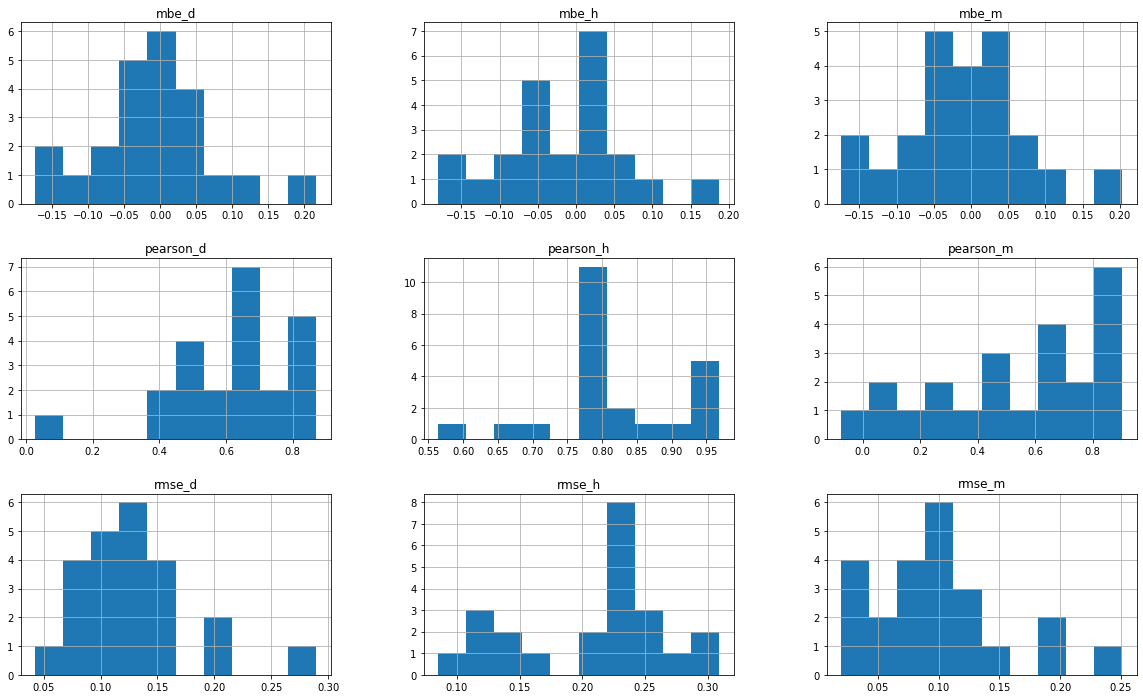

In [13]:
boxplot = selected_results2.boxplot(figsize=(20,6))
selected_results2.hist(figsize=(20,12))
selected_results2.shape

(6, 9)

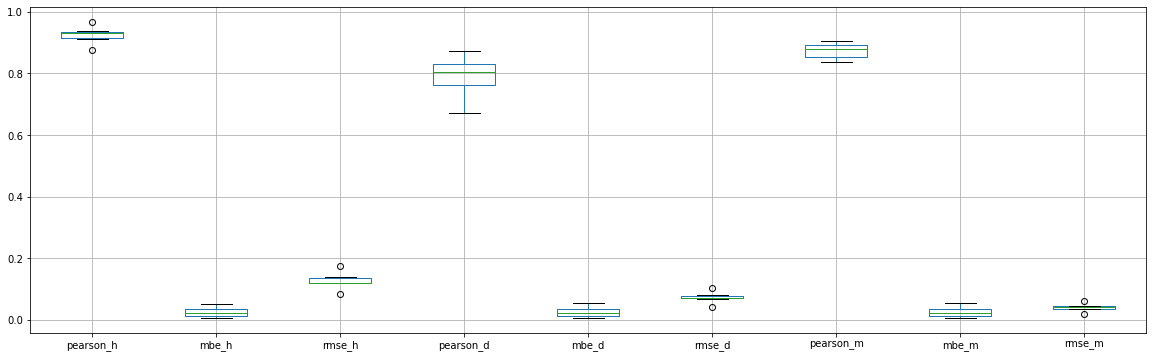

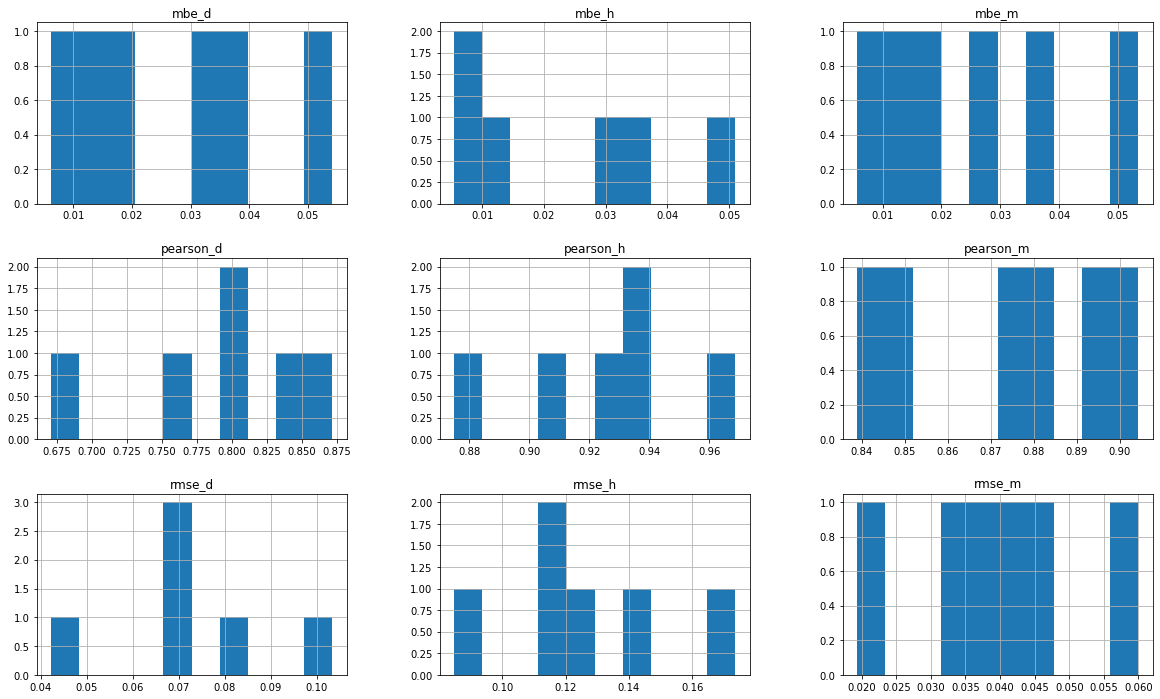

In [14]:
boxplot = selected_results3.boxplot(figsize=(20,6))
selected_results3.hist(figsize=(20,12))
selected_results3.shape

## 5) Indicators calculation for the validation renewables ninja

In [304]:
#import the data from rn
rn_pre2 = pd.read_csv("timeseries_rn.csv", index_col=0, parse_dates = True)
rn_pre1 = rn_pre2.iloc[:][:-1].tz_localize('UTC').copy()
#the dailight summer time in chile changes from year to year
#the next lines create in a very explcit way a new time series with corrected dts
rn_pre1_dst_2014 = rn_pre1["2014-04-27":"2014-09-07"].shift(periods=-1).copy()
rn_pre1_dst_2016 = rn_pre1["2016-05-15":"2016-08-14"].shift(periods=-1).copy()
rn_pre1_dst_2017 = rn_pre1["2017-05-14":"2017-08-14"].shift(periods=-1).copy()
rn_pre1_dst_2018 = rn_pre1["2018-05-13":"2018-08-12"].shift(periods=-1).copy()

rn = rn_pre1.copy()
rn.loc["2014-04-27":"2014-09-07"] = rn_pre1_dst_2014
rn.loc["2016-05-15":"2016-08-14"] = rn_pre1_dst_2016 
rn.loc["2017-05-14":"2017-08-14"] = rn_pre1_dst_2017
rn.loc["2018-05-13":"2018-08-12"] = rn_pre1_dst_2018


In [305]:
indicators_rn = pd.DataFrame(columns=("pearson_h","p-value_h",
                                   "mbe_h",
                                   "rmse_h",
                                   "observations",
                                   "pearson_d",
                                   "mbe_d",
                                   "rmse_d",
                                   "days",
                                   "pearson_m",
                                   "mbe_m",
                                   "rmse_m",
                                   "months"), index=rn.columns)
for plant in rn.columns:
    if np.sum(reference_pre2[plant]["2014":"2018"]) > 0:
        #print(plant)
        comp_pre = pd.DataFrame(columns=("new","reference"), index=rn.index)
        comp_pre["new"] = np.array(rn[plant]["2014":"2018"]).copy()
        comp_pre["reference"] = reference_pre2[plant]["2014":"2018"].copy()
        comp = comp_pre.dropna().copy()
        new = comp["new"]
        reference = comp["reference"]
        pearson = sp.stats.pearsonr(reference.astype(float), new.astype(float))
        indicators_rn.loc[plant]["pearson_h"] = pearson[0]
        indicators_rn.loc[plant]["p-value_h"] = pearson[1]
        indicators_rn.loc[plant]["mbe_h"] = (np.sum(new-reference))/np.sum(reference.size)
        observations = comp.size/comp.columns.size
        indicators_rn.loc[plant]["observations"] = observations
        indicators_rn.loc[plant]["rmse_h"] = np.sqrt((np.sum((new-reference)**2))/(observations))
        new_avg_day = round(new.resample('D').mean(),4).dropna().copy()
        days = new_avg_day.size
        days_in_study_period = 1825
        indicators_rn.loc[plant]["days"] = days/days_in_study_period
        reference_avg_day = round(reference.astype(float).resample('D').mean(),4).dropna().copy()
        pearson_days = sp.stats.pearsonr(reference_avg_day.astype(float), new_avg_day.astype(float))
        indicators_rn.loc[plant]["pearson_d"] = pearson_days[0]
        indicators_rn.loc[plant]["mbe_d"] = (np.sum(new_avg_day-reference_avg_day))/np.sum(reference_avg_day.size)
        indicators_rn.loc[plant]["rmse_d"] = np.sqrt((np.sum((new_avg_day-reference_avg_day)**2))/(np.sum(reference_avg_day.size)))
        new_avg_month = round(new.resample('M').mean(),4).dropna().copy()
        months = new_avg_month.size 
        reference_avg_month = round(reference.astype(float).resample('M').mean(),4).dropna().copy()
        pearson_months = sp.stats.pearsonr(reference_avg_month.astype(float), new_avg_month.astype(float))
        indicators_rn.loc[plant]["pearson_m"] = pearson_months[0]
        indicators_rn.loc[plant]["mbe_m"] = (np.sum(new_avg_month-reference_avg_month))/np.sum(reference_avg_month.size)
        indicators_rn.loc[plant]["rmse_m"] = np.sqrt((np.sum((new_avg_month-reference_avg_month)**2))/(np.sum(reference_avg_month.size)))
        monthss_in_study_period = 60
        indicators_rn.loc[plant]["months"] = months/monthss_in_study_period
        #print(str(plant)+"   "+str(months))
        #fig = plt.figure(figsize=(20,6))
        #plt.plot(new_avg_day)
        #plt.plot(reference_avg_day)
        #fig = plt.figure(figsize=(20,6))
        #plt.plot(new)
        #plt.plot(reference)
        #plt.show()
        #print(indicators_rn.loc[plant])


In [306]:
indicators_rn_clean = indicators_rn.dropna().copy()
indicators_rn_clean.to_csv("indicators_rn_ERA5_land.csv")

(57, 9)


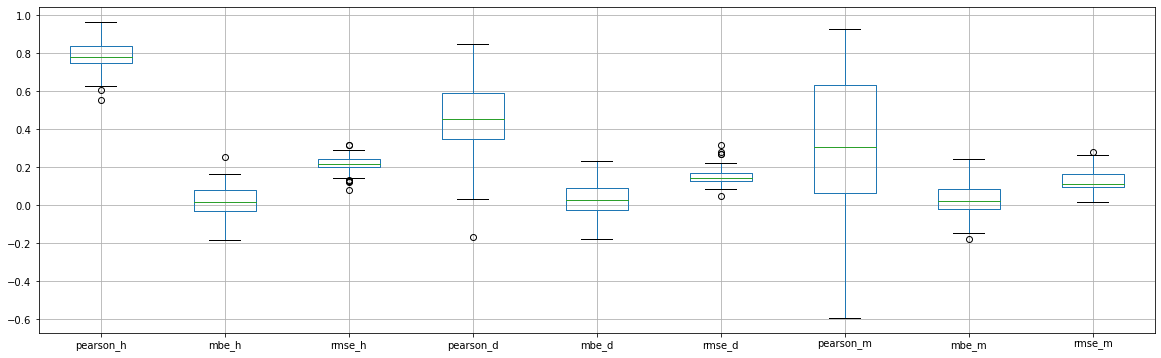

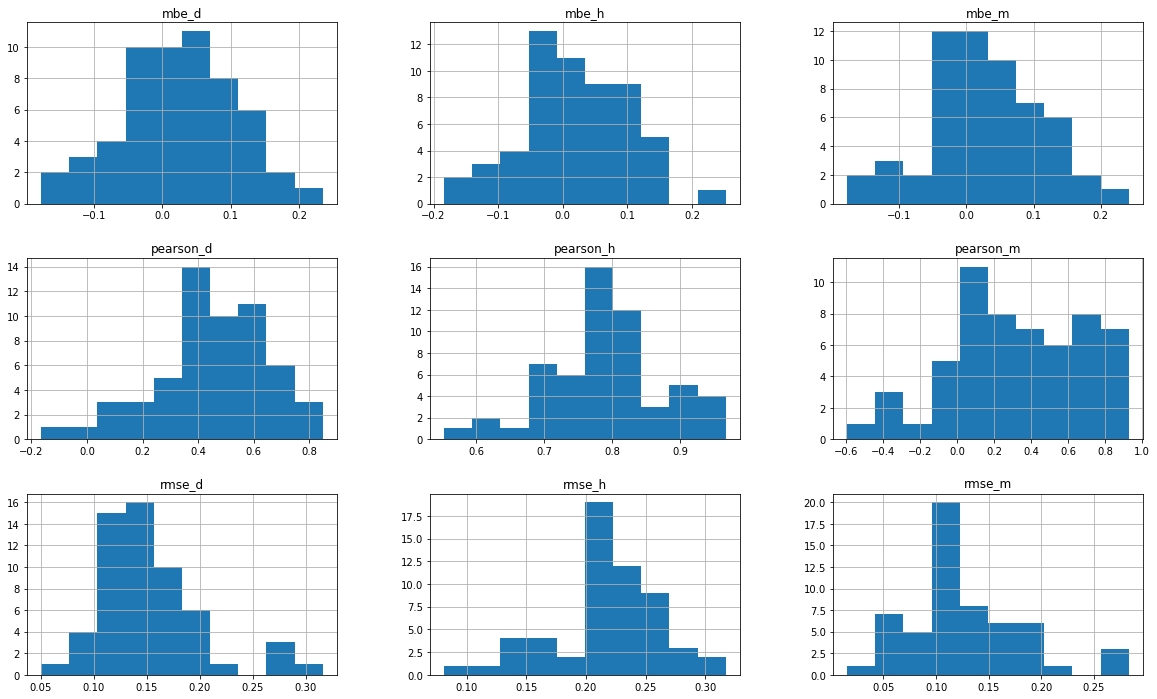

In [307]:
results_rn_pre = pd.read_csv("indicators_rn_ERA5_land.csv", index_col=0)

selected_results_rn =  results_rn_pre.loc[results_rn_pre["months"] > minimum_months].drop(["observations", "p-value_h","days","months"], axis=1).copy()
results_rn = results_rn_pre.drop(["observations", "p-value_h","days","months"], axis=1).copy()
boxplot = results_rn.boxplot(figsize=(20,6))
print(results_rn.shape)
results_rn.hist(figsize=(20,12))
#selected_results2 excludes 34 installations with objects, 
#long period of test before going fully online, long periods of missing values after commisioning day 
results_rn2 = results_rn.drop(["BELLAVISTA", "CARRERA PINTO ETAPA I",
                                           "CHANARES", "CONEJO SOLAR",
                                           "CORDILLERILLA","EL DIVISADERO",
                                           "FV BOLERO", "LAS TURCAS",
                                           "LOS PUQUIOS", "LUZ DEL NORTE",
                                           "PAMPA SOLAR NORTE", "PARQUE SOLAR CUZ CUZ",
                                           "PARQUE SOLAR FINIS TERRAE", "PARQUE SOLAR PAMPA CAMARONES",
                                           "PFV LAGUNILLA", "PFV LOS LOROS",
                                           "PLANTA PV CERRO DOMINADOR", "PMGD PICA PILOT",
                                           "PV SALVADOR", "QUILAPILUN",
                                           "SDGX01", "SOLAR ANTAY",
                                           "SOLAR DIEGO DE ALMAGRO", "SOLAR EL AGUILA I",
                                           "SOLAR EL ROMERO", "SOLAR ESPERANZA",
                                           "SOLAR HORMIGA", "SOLAR JAVIERA",
                                           "SOLAR LA SILLA", "SOLAR LAS TERRAZAS",
                                           "SOLAR LLANO DE LLAMPOS", "SOLAR SAN ANDRES",
                                           "SOLAR TECHOS ALTAMIRA", "TAMBO REAL"])
results_rn3 = results_rn2.drop(["PUERTO SECO SOLAR", "URIBE SOLAR",
                               "ANDES SOLAR", "LA CHAPEANA","LA QUINTA SOLAR",
                                "PILOTO SOLAR CARDONES", "SAN FRANCISCO SOLAR",
                                "SANTA JULIA","MARIA ELENA FV","LALACKAMA",
                                "LALACKAMA 2","LAS ARAUCARIAS","SOLAR CHUCHINI",
                                "SOLAR JAMA 1", "SOLAR JAMA 2","TILTIL SOLAR","VALLE DE LA LUNA II"])

(23, 9)

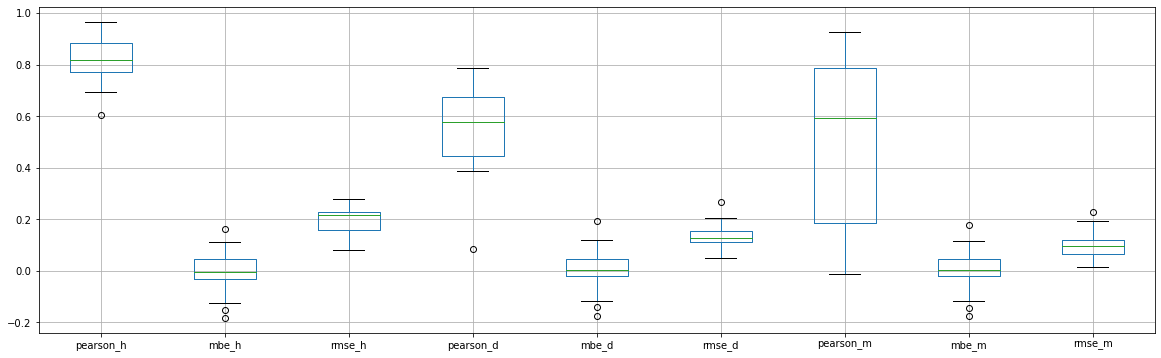

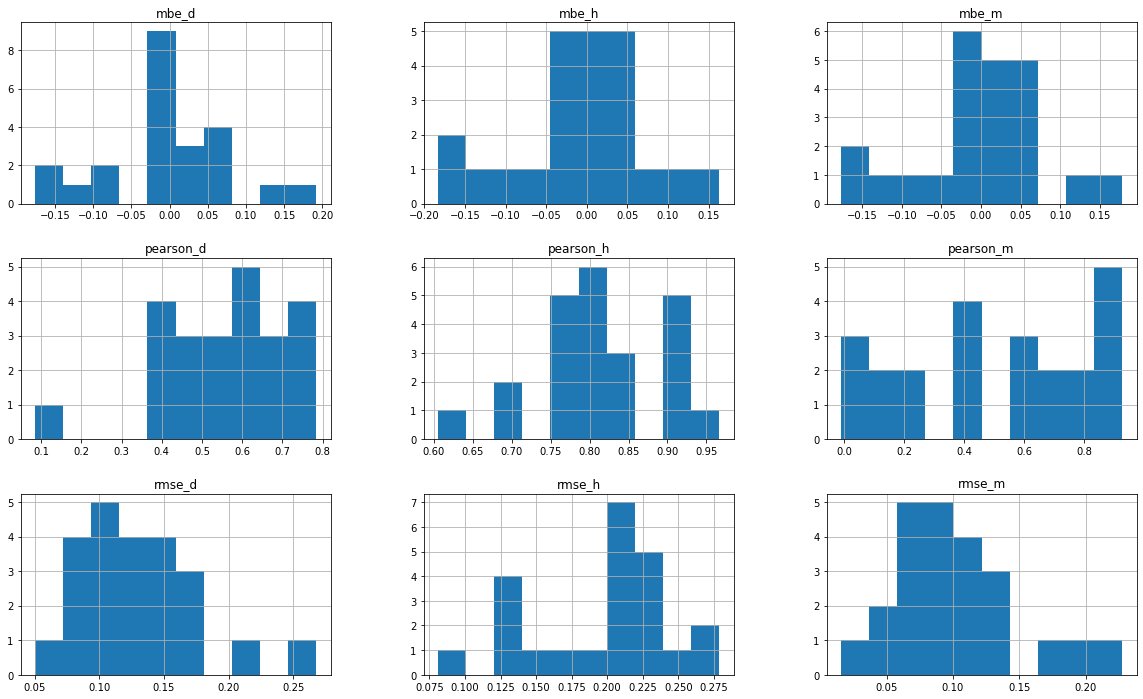

In [308]:
boxplot = results_rn2.boxplot(figsize=(20,6))
#results_rn.hist(cumulative=True, density=1, bins=57, figsize=(20,12))
results_rn2.hist(figsize=(20,12))
results_rn2.shape

LAS MOLLACAS
LUNA DEL NORTE
SOL DEL NORTE
SOLAR PSF LOMAS COLORADAS
SOLAR SANTA CECILIA
SPS LA HUAYCA


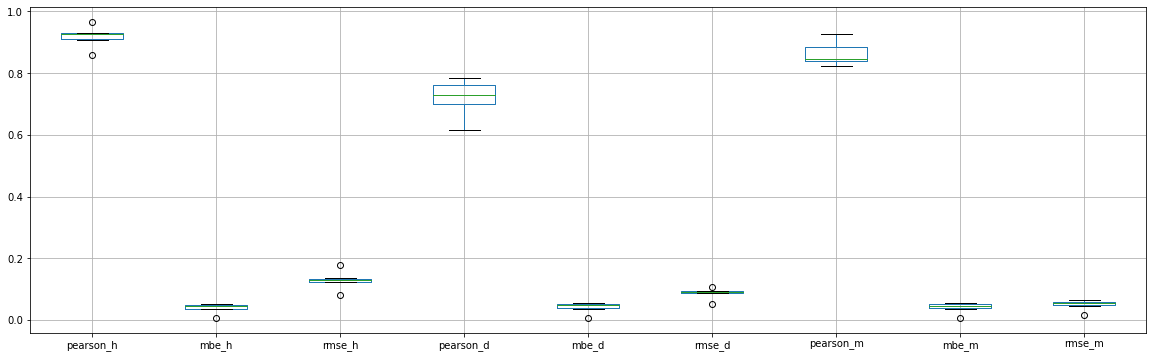

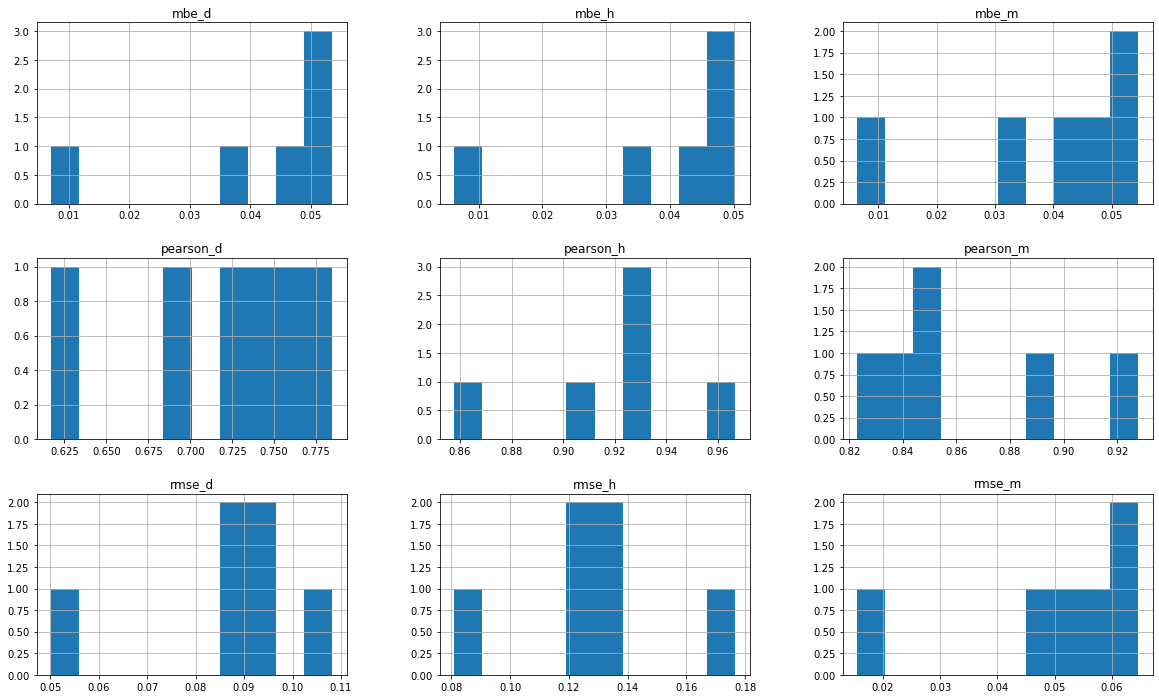

In [309]:
boxplot = results_rn3.boxplot(figsize=(20,6))
results_rn3.hist(figsize=(20,12))
results_rn3.shape
for i in results_rn3.index:
    print(i)
    

## Individual plant testing

In [ ]:
#for plant in selected_results.index:
    print(plant)
    print(selected_results.loc[plant])
    fig = plt.figure(figsize=(20,6))
    plt.plot(calculated[plant])
    plt.plot(rn[plant])
    plt.plot(reference_pre2[plant])
    plt.show()

In [ ]:
plt.plot(calculated[plant])
plt.plot(rn[plant])
reference_pre2[plant].plot()
pd.to_datetime(rn.index)
#print(calculated.index)
#print(rn.index)

In [ ]:
results.loc["SOLAR LLANO DE LLAMPOS"]

In [ ]:
start = "2014-01-01"
ende = "2018-12-31"
#plant = "LALACKAMA"
#plant = "LAS MOLLACAS"
#plant = "PILOTO SOLAR CARDONES"
#plant = "SOLAR TECHOS ALTAMIRA"
#plant = "LUNA DEL NORTE"
plant = "BELLAVISTA"
#plant = "SOL DEL NORTE"
comp_pre = pd.DataFrame(columns=("calculated","RN","reference"), index=calculated.index)
comp_pre["calculated"] = np.array(calculated[plant]["2014":"2018"].copy())
comp_pre["reference"] = np.array(reference_pre2[plant]["2014":"2018"].copy())
comp_pre["RN"] = np.array(rn[plant]["2014":"2018"].copy())
comp = comp_pre[:][start:ende]
#comp = comp_pre.dropna().copy()
#comp.plot.area(figsize=(20,6), stacked=False)
#comp_pre["reference"].plot()
#reference_pre2[plant].plot()

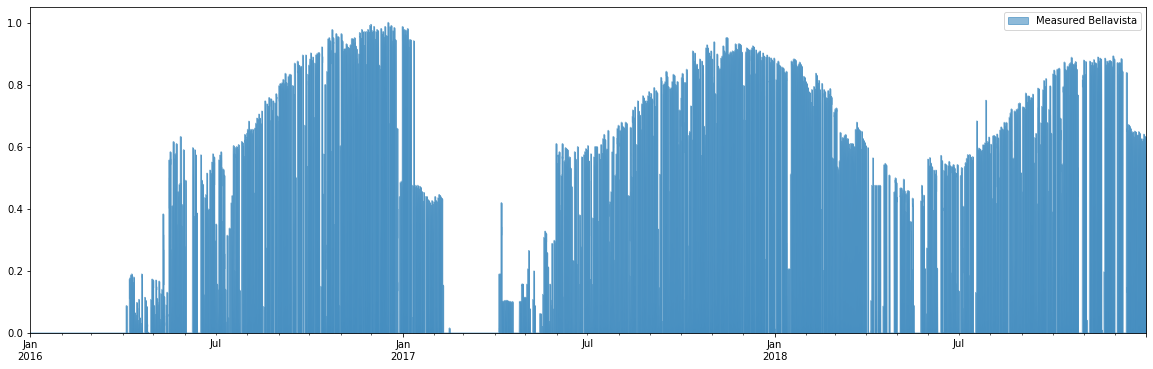

In [277]:
#artifacts example
start = "2016-01-01"
ende = "2018-12-31"
plant = "BELLAVISTA"
comp_pre = pd.DataFrame(index=reference_pre2.index)
comp_pre["Measured Bellavista"] = np.array(reference_pre2[plant].copy())
comp = comp_pre[:][start:ende]
comp.plot.area(figsize=(20,6), stacked=False)

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


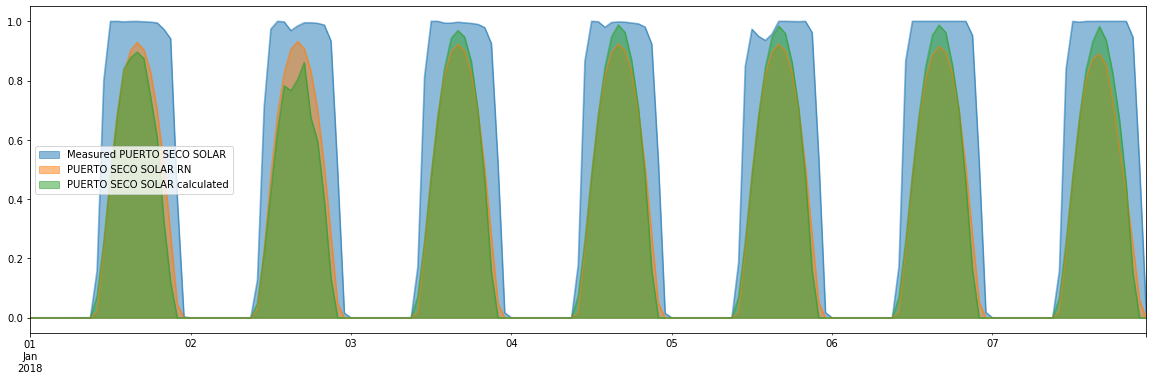

In [330]:
#tracker/inverter example
start = "2018-01-01"
ende = "2018-01-07"
plant = "PUERTO SECO SOLAR"
comp_pre = pd.DataFrame(index=calculated.index)
comp_pre["Measured PUERTO SECO SOLAR"] = reference_pre2[plant]["2014":"2018"].copy()
comp_pre["PUERTO SECO SOLAR RN"] = rn[plant]["2014":"2018"].copy()
comp_pre["PUERTO SECO SOLAR calculated"] = calculated[plant]["2014":"2018"].copy()
comp = comp_pre[:][start:ende]
comp.plot.area(figsize=(20,6), stacked=False)

## Deseasonalize the timeseries of the plants with the same assumptions

In [217]:
#create a data frame to store the clearsky values for each location
cs_df = pd.DataFrame(columns=results_rn3.index, index=pd.to_datetime(date_range))


In [218]:
for location in results_rn3.index:
    lat = installations_chile.loc[location]['latitude']
    lon = installations_chile.loc[location]['longitude']-360
    print(str(location)+" "+str(lat)+" "+str(lon))
    tus = Location(lat, lon, 'Chile/Continental')
    cs = tus.get_clearsky(pd.to_datetime(date_range))
    cs_df[location] = cs.ghi/np.max(cs.ghi)

LAS MOLLACAS -30.676327020803715 -71.2255644211649
LUNA DEL NORTE -30.040192044276893 -70.68000578333931
SOL DEL NORTE -30.04006352202994 -70.68370578967495
SOLAR PSF LOMAS COLORADAS -31.18638247016862 -71.02254980543262
SOLAR SANTA CECILIA -29.117177584831456 -70.91339171901228
SPS LA HUAYCA -20.45456065243675 -69.53401235824447


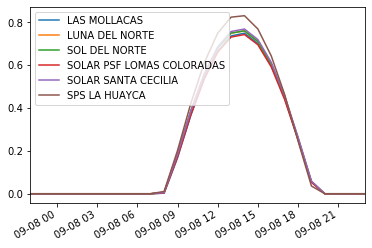

In [219]:
cs_df["2014-09-07 22:00" :"2014-09-08"].plot()

In [220]:
cs_pre = cs_df.tz_convert('UTC').copy()
cs_dst_2014 = cs_pre["2014-04-27":"2014-09-08 00:00"].shift(periods=-1).copy()
cs_dst_2016 = cs_pre["2016-05-15":"2016-08-15 00:00"].shift(periods=-1).copy()
cs_dst_2017 = cs_pre["2017-05-14":"2017-08-15 00:00"].shift(periods=-1).copy()
cs_dst_2018 = cs_pre["2018-05-13":"2018-08-13 00:00"].shift(periods=-1).copy()

cs = cs_pre.copy()
cs.loc["2014-04-27":"2014-09-08 00:00"] = cs_dst_2014
cs.loc["2016-05-15":"2016-08-15 00:00"] = cs_dst_2016 
cs.loc["2017-05-14":"2017-08-15 00:00"] = cs_dst_2017
cs.loc["2018-05-13":"2018-08-13 00:00"] = cs_dst_2018

In [221]:
#create data frames for the deseasonalized time series
des_ref = pd.DataFrame(columns=results_rn3.index, index=reference_pre2.index)
des_era5 = pd.DataFrame(columns=results_rn3.index, index=reference_pre2.index)
des_rn = pd.DataFrame(columns=results_rn3.index, index=reference_pre2.index)
#calculate the deseasonalized time series
for plant in results_rn3.index:
    des_ref[plant] = reference_pre2[plant] - cs[plant]
    des_era5[plant] = calculated[plant] - cs[plant]
    des_rn[plant] = rn[plant] - cs[plant]

In [337]:
#calculate the indicators for the desasonalized time series
indicators_cs = pd.DataFrame(columns=("pearson_h_era5","pearson_h_rn",
                                   "mbe_h_era5","mbe_h_rn",
                                   "rmse_h_era5","rmse_h_rn",
                                   "pearson_d_era5", "pearson_d_rn",
                                   "mbe_d_era5", "mbe_d_rn",
                                   "rmse_d_era5", "rmse_d_rn",
                                   "pearson_m_era5", "pearson_m_rn",
                                   "mbe_m_era5", "mbe_m_rn",
                                   "rmse_m_era5", "rmse_m_rn"), index=results_rn3.index)
for plant in results_rn3.index:
    #print(plant)
    comp_pre = pd.DataFrame(columns=("era5","rn","reference"), index=rn.index)
    comp_pre["rn"] = des_rn[plant]["2014":"2018"].copy()
    comp_pre["era5"] = des_era5[plant]["2014":"2018"].copy()
    comp_pre["reference"] = des_ref[plant]["2014":"2018"].copy()
    comp = comp_pre.dropna().copy()
    rnin = comp["rn"]
    era5 = comp["era5"]
    reference = comp["reference"]
    #print(reference.size)
    #hourly indicators
    pearson_rn = sp.stats.pearsonr(reference.astype(float), rnin.astype(float))
    pearson_era5 = sp.stats.pearsonr(reference.astype(float), era5.astype(float))
    indicators_cs.loc[plant]["pearson_h_rn"] = pearson_rn[0]
    indicators_cs.loc[plant]["pearson_h_era5"] = pearson_era5[0]
    indicators_cs.loc[plant]["mbe_h_rn"] = (np.sum(rnin-reference))/np.sum(reference.size)
    indicators_cs.loc[plant]["mbe_h_era5"] = (np.sum(era5-reference))/np.sum(reference.size)
    indicators_cs.loc[plant]["rmse_h_rn"] = np.sqrt((np.sum((rnin-reference)**2))/(reference.size))
    indicators_cs.loc[plant]["rmse_h_era5"] = np.sqrt((np.sum((era5-reference)**2))/(reference.size))
    #daily indicators
    rn_avg_day = round(rnin.resample('D').mean(),4).dropna().copy()
    era5_avg_day = round(era5.resample('D').mean(),4).dropna().copy()
    reference_avg_day = round(reference.astype(float).resample('D').mean(),4).dropna().copy()
    days = reference_avg_day.size
    pearson_days_rn = sp.stats.pearsonr(reference_avg_day.astype(float), rn_avg_day.astype(float))
    pearson_days_era5 = sp.stats.pearsonr(reference_avg_day.astype(float), era5_avg_day.astype(float))
    indicators_cs.loc[plant]["pearson_d_era5"] = pearson_days_era5[0]
    indicators_cs.loc[plant]["pearson_d_rn"] = pearson_days_rn[0]
    indicators_cs.loc[plant]["mbe_d_era5"] = (np.sum(era5_avg_day-reference_avg_day))/days
    indicators_cs.loc[plant]["mbe_d_rn"] = (np.sum(rn_avg_day-reference_avg_day))/days
    indicators_cs.loc[plant]["rmse_d_era5"] = np.sqrt((np.sum((era5_avg_day-reference_avg_day)**2))/days)
    indicators_cs.loc[plant]["rmse_d_rn"] = np.sqrt((np.sum((rn_avg_day-reference_avg_day)**2))/days)
    #monthly indicators
    rn_avg_month = round(rnin.resample('M').mean(),4).dropna().copy()
    era5_avg_month = round(era5.resample('M').mean(),4).dropna().copy()
    months = new_avg_month.size
    reference_avg_month = round(reference.astype(float).resample('M').mean(),4).dropna().copy()
    pearson_months_rn = sp.stats.pearsonr(reference_avg_month.astype(float), rn_avg_month.astype(float))
    pearson_months_era5 = sp.stats.pearsonr(reference_avg_month.astype(float), era5_avg_month.astype(float))
    indicators_cs.loc[plant]["pearson_m_rn"] = pearson_months_rn[0]
    indicators_cs.loc[plant]["pearson_m_era5"] = pearson_months_era5[0]
    indicators_cs.loc[plant]["mbe_m_rn"] = (np.sum(rn_avg_month-reference_avg_month))/months
    indicators_cs.loc[plant]["rmse_m_rn"] = np.sqrt((np.sum((rn_avg_month-reference_avg_month)**2))/months)
    indicators_cs.loc[plant]["mbe_m_era5"] = (np.sum(era5_avg_month-reference_avg_month))/months
    indicators_cs.loc[plant]["rmse_m_era5"] = np.sqrt((np.sum((era5_avg_month-reference_avg_month)**2))/months)
    

In [338]:
print(indicators_cs)

                          pearson_h_era5 pearson_h_rn  mbe_h_era5    mbe_h_rn  \
LAS MOLLACAS                    0.522059     0.457865   0.0510387   0.0496328   
LUNA DEL NORTE                  0.786773     0.744193   0.0130929   0.0502563   
SOL DEL NORTE                   0.788469     0.736586  0.00960589   0.0467639   
SOLAR PSF LOMAS COLORADAS       0.781297     0.752429   0.0350971   0.0419173   
SOLAR SANTA CECILIA             0.720241      0.72897   0.0295982   0.0348464   
SPS LA HUAYCA                    0.84676     0.840098  0.00537236  0.00610645   

                          rmse_h_era5 rmse_h_rn pearson_d_era5 pearson_d_rn  \
LAS MOLLACAS                 0.173683  0.176672       0.728444     0.686075   
LUNA DEL NORTE               0.118863  0.128635       0.878781      0.82008   
SOL DEL NORTE                0.118474  0.129593       0.875935     0.810819   
SOLAR PSF LOMAS COLORADAS    0.122949  0.122539       0.903804      0.83846   
SOLAR SANTA CECILIA          0.139248

In [340]:
indicators_cs.to_csv("indicators_cs_ERA5_land_and_rn.csv")
indicators_des = pd.read_csv("indicators_cs_ERA5_land_and_rn.csv", index_col=0)

In [ ]:
boxplot = indicators_des.boxplot(figsize=(28,10))
indicators_des.hist(figsize=(20,12))

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


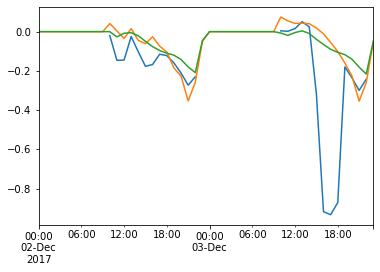

In [334]:
plant = "SOLAR SANTA CECILIA"
start = "2017-12-2"
end = "2017-12-3"
#cs[location][start:end].plot()
#calculated[plant][start:end].plot()
des_ref[plant][start:end].plot()
des_era5[plant][start:end].plot()
des_rn[plant][start:end].plot()

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


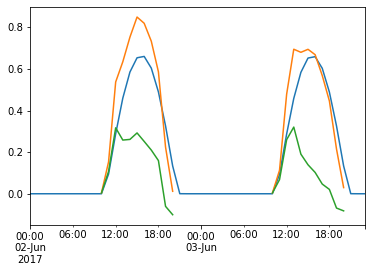

In [335]:
plant = "SOLAR SANTA CECILIA"
start = "2017-6-2"
end = "2017-6-3"
cs[location][start:end].plot()
reference_pre2[plant][start:end].plot()
des_ref[plant][start:end].plot()

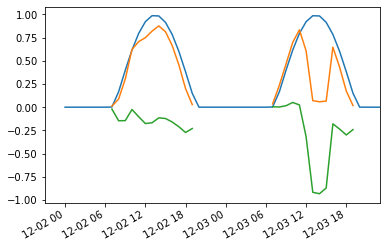

In [336]:
plant = "SOLAR SANTA CECILIA"
start = "2017-12-2"
end = "2017-12-3"
cs_df[location][start:end].plot()
reference_pre2[plant][start:end].plot()
des_ref[plant][start:end].plot()